# Transformer Encoder Learns Math

In this notebook we'll teach a simple tranformer encoder to predict the signs of sums specified as sequences of strings.

For example "plus four minus seven minus three" which represents the "+4+7-3" would be labeled as positive and "minus five plus seven minus eight" would be labeled as non-positive.  We don't label it as "negative" because we're going to count zero as non-positive to give us a binary classification problem.

We'll generate thousands of samples for training.  What's remarkable is that a transformer encoder model with single-head attention and two transformer layers can learn to classify these sums with nearly 100% accuracy without having any knowledge of the underlying math.  

Moreover the simplicity of this example allows us to build the model from scratch and to be able to inspect the attention weights to see how transformer is "thinking."  

## Imports

In [45]:
# imports and configuration

# uncomment to use a custom environment file
# from dotenv import load_dotenv
# load_dotenv('../main.env')

import os
from pathlib import Path

MODELS_PATH = Path(os.getenv('MODELS_PATH'))
DATA_PATH = Path(os.getenv('DATA_PATH'))
TORCH_HOME = Path(os.getenv('TORCH_HOME'))

print(f'{MODELS_PATH=}')
print(f'{DATA_PATH=}')
print(f'{TORCH_HOME=}')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from introdl.utils import get_device, load_results, load_model
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics

from viz_functions import visualize_positional_encodings, display_attention
from viz_functions import plot_attention_weights, plot_attention_weights_widget

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

MODELS_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/downloads')


## Data Generation and DataLoaders

In [46]:
class ArithmeticSequenceDataset(Dataset):
    """
    A PyTorch Dataset class for generating and handling arithmetic sequences.
    Attributes:
        num_samples (int): The number of samples in the dataset.
        max_length (int): The maximum number of digits in each sequence.
        num_map (dict): A dictionary mapping number words to their integer values.
        total_positive (int): The total number of sequences with a positive sum.
        correct_dominant_sign (int): The number of sequences where the dominant sign matches the label.
        data (list): A list of generated arithmetic sequences.
        labels (list): A list of labels corresponding to the sequences.
    Methods:
        __init__(num_samples, max_length=20, seed=None):
            Initializes the dataset with the given number of samples and maximum sequence length.
        generate_dataset(num_samples, max_length):
            Generates a dataset of arithmetic sequences and their corresponding labels.
        __len__():
            Returns the number of samples in the dataset.
        __getitem__(idx):
            Returns the sequence and label at the specified index.
    """

    def __init__(self, num_samples, max_length=20, seed=None):
        np.random.seed(seed)
        self.num_samples = num_samples
        self.max_length = max_length
        self.num_map = {
            "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
            "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9
        }
        self.total_positive = 0
        self.correct_dominant_sign = 0
        self.data, self.labels = self.generate_dataset(num_samples, max_length)

    def generate_dataset(self, num_samples, max_length):
        operators = ["plus", "minus"]
        digits = list(self.num_map.keys())  # Including "zero"
        sequences = []
        labels = []
        unique_sequences = set()

        while len(sequences) < num_samples:
            # Generate a random sequence
            length = np.random.randint(1, max_length + 1)
            numbers = np.random.choice(digits, length, replace=True)
            ops = np.random.choice(operators, length, replace=True)
            sequence = " ".join([f"{op} {num}" for op, num in zip(ops, numbers)])
            
            # Ensure uniqueness
            if sequence in unique_sequences:
                continue  # Skip and regenerate if not unique

            unique_sequences.add(sequence)

            # Calculate the sum
            sum_numbers = np.sum([
                self.num_map[num] if op == "plus" else -self.num_map[num] 
                for op, num in zip(ops, numbers)
            ])
            label = int(sum_numbers > 0)  # Return integers 0 or 1
            self.total_positive += label

            # Track dominant sign correctness
            plus_count = sum(ops=="plus")
            minus_count = sum(ops=="minus")
            dominant_sign = 1 if plus_count > minus_count else 0
            if dominant_sign == label:
                self.correct_dominant_sign += 1

            # Store the sequence and label
            sequences.append(sequence)
            labels.append(label)
        
        return sequences, labels

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [47]:
num_samples = 20000
dataset = ArithmeticSequenceDataset(num_samples, 10, seed=42)
torch.manual_seed(42)
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

Let's see a few examples:

In [48]:
for i in range(3):
    print(f"Sequence: {dataset.data[i]} => Label: {dataset.labels[i]}")

Sequence: plus three plus seven minus four plus six minus nine minus two minus six => Label: 0
Sequence: minus five minus four minus one => Label: 0
Sequence: plus one plus four plus zero plus nine minus five minus eight => Label: 1


To use these sequences to train a transformer model we need to add some special tokens: "<CLS>" and "<PAD>".  The "<CLS>", or classifier, token will be prepended to each sequence.  The transformed output corresponding to the "<CLS>" token is what is passed to the final classification layer of our model.  The "<PAD>" token is used to add padding to the sequences in each batch to make all sequences the same length as the longest sequence in the batch.  This is needed so that the model can process sequences in parallel.  We instruct the model to ignore the "<PAD>" tokens in its computations.

In [49]:
# <PAD> token must be 0 in our vocabulary 
vocab = {
    "<PAD>": 0, "<CLS>": 1, "plus": 2, "minus": 3,
    "zero": 4, "one": 5, "two": 6, "three": 7, "four": 8,
    "five": 9, "six": 10, "seven": 11, "eight": 12, "nine": 13
}

# custom collate function
def pad_batch(batch):
    """
    Pads a batch of sequences to the same length and converts them to tensor format.
    Args:
        batch (list of tuples): A list of tuples where each tuple contains a sequence (str) and a label (int).
    Returns:
        tuple: A tuple containing:
            - torch.Tensor: A tensor of padded sequences with shape (batch_size, max_length + 1).
            - torch.Tensor: A tensor of labels with shape (batch_size,).
    Note:
        - Each sequence is tokenized by splitting on whitespace.
        - A special token '<CLS>' is added at the beginning of each sequence.
        - Sequences are padded with the '<PAD>' token to match the length of the longest sequence in the batch.
        - The `vocab` dictionary is used to convert tokens to their corresponding indices.
    """

    sequences, labels = zip(*batch)
    max_length = max(len(seq.split()) for seq in sequences)
    padded_sequences = []
    for seq in sequences:
        tokens = ['<CLS>'] + seq.split()
        padded = [vocab[token] for token in tokens] + [vocab["<PAD>"]] * (max_length + 1 - len(tokens))
        padded_sequences.append(padded)
    return torch.tensor(padded_sequences), torch.tensor(labels)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, collate_fn=pad_batch)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False, collate_fn=pad_batch)

In [50]:
x, labels = next(iter(train_loader))
print(x.shape)
embedding = nn.Embedding(14,16)
x = embedding(x)
print('embedding shape', x.shape)
query = nn.Linear(16, 16)
key = nn.Linear(16, 16)
value = nn.Linear(16, 16)
Q = query(x)
K = key(x)
V = value(x)
print(Q.shape, K.shape, V.shape)
attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(16)
attention_weights = F.softmax(attention_scores, dim=-1)
A = attention_weights[0].squeeze().detach().numpy()
print(f'{A.shape=}')
row_sums = A.sum(axis=1)
col_sums = A.sum(axis=0)
print("Row sums:", row_sums)
print("Column sums:", col_sums)

torch.Size([100, 21])
embedding shape torch.Size([100, 21, 16])
torch.Size([100, 21, 16]) torch.Size([100, 21, 16]) torch.Size([100, 21, 16])
A.shape=(21, 21)
Row sums: [1.         1.0000001  0.99999994 1.0000001  0.99999994 0.99999994
 0.99999994 0.99999994 1.         0.99999994 0.99999994 1.0000001
 1.         0.99999994 0.99999994 0.99999994 0.9999999  1.0000001
 1.0000001  1.0000001  0.9999999 ]
Column sums: [1.0522648  1.1210576  0.9067843  1.1210576  0.91841036 0.8935491
 0.8766362  0.8935491  1.0005925  0.8935491  0.91841036 1.1210576
 1.0534297  0.8935491  0.9067843  0.8935491  1.1934353  1.1210576
 0.9067843  1.1210576  1.1934353 ]


## Single Head Attention Transformer Encoder from Scratch

PyTorch has ready made classes for transformers, but we'll implement our own here so see the pieces and how they fit together.  We'll use only single-head attention to keep things simple.  Using our own implementation also makes it simpler to extract the attention weights for inspection after training.

Watch the video below to get more details about the code.

INSERT VIDEO HERE.

In [69]:
class SingleHeadAttention(nn.Module):
    """
    Implements single-head attention for transformer models.
    """

    def __init__(self, embed_dim):
        """
        Initializes the SingleHeadAttention module.

        Args:
            embed_dim (int): Dimensionality of the embedding space.
        """
        super(SingleHeadAttention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = math.sqrt(embed_dim)
        self.attention_weights = None

    def forward(self, x, mask=None):
        """
        Forward pass for single-head attention.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).
            mask (torch.Tensor): Mask tensor of shape (batch_size, seq_length, seq_length).

        Returns:
            torch.Tensor: Output tensor after applying attention.
        """
        Q = self.query(x)  # Shape: (batch_size, seq_length, embed_dim)
        K = self.key(x)
        V = self.value(x)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # Shape: (batch_size, seq_length, seq_length)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        self.attention_weights = F.softmax(attention_scores, dim=-1)  # Shape: (batch_size, seq_length, seq_length)
        return torch.matmul(self.attention_weights, V)  # Shape: (batch_size, seq_length, embed_dim)

class TransformerLayer(nn.Module):
    """
    A single transformer layer comprising attention, residual connections,
    layer normalization, and a feedforward network.
    """

    def __init__(self, embed_dim, hidden_dim):
        """
        Initializes the TransformerLayer.

        Args:
            embed_dim (int): Dimensionality of the embedding space.
            hidden_dim (int): Dimensionality of the hidden layer in the feedforward network.
        """
        super(TransformerLayer, self).__init__()
        self.attention = SingleHeadAttention(embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, mask=None):
        """
        Forward pass for the transformer layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).
            mask (torch.Tensor): Mask tensor of shape (batch_size, seq_length, seq_length).

        Returns:
            torch.Tensor: Output tensor after applying attention and feedforward network.
        """
        attn_output = self.attention(x, mask)  # Shape: (batch_size, seq_length, embed_dim)
        x = self.norm1(x + attn_output)
        x2 = self.mlp(x)  # Shape: (batch_size, seq_length, embed_dim)
        return self.norm2(x + x2)

    def get_attention_weights(self):
        """
        Retrieves attention weights.

        Returns:
            torch.Tensor: Attention weights from the SingleHeadAttention module.
        """
        return self.attention.attention_weights

class PositionalEncoding(nn.Module):
    """
    Adds positional encoding to input embeddings to incorporate positional information.
    """

    def __init__(self, d_model, max_len=500):
        """
        Initializes the PositionalEncoding module.

        Args:
            d_model (int): Dimensionality of the embedding space.
            max_len (int): Maximum length of sequences.
        """
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Forward pass for adding positional encoding.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).

        Returns:
            torch.Tensor: Input tensor with positional encoding added.
        """
        return x + self.pe[:, :x.size(1)]

class SingleHeadTransformerEncoder(nn.Module):
    """
    Transformer encoder with single-head attention.
    """

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers):
        """
        Initializes the SingleHeadTransformerEncoder.

        Args:
            vocab_size (int): Vocabulary size.
            embed_dim (int): Dimensionality of the embedding space.
            hidden_dim (int): Dimensionality of the hidden layer in the feedforward network.
            num_classes (int): Number of output classes.
            num_layers (int): Number of transformer layers.
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embed_dim)
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(embed_dim, hidden_dim) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        """
        Forward pass for the transformer encoder.

        Args:
            x (torch.Tensor): Input tensor of token indices.

        Returns:
            torch.Tensor: Output logits for classification.
        """
        mask = (x != 0).unsqueeze(1).expand(-1, x.size(1), -1)  # Shape: (batch_size, seq_length, seq_length)
        x = self.embedding(x)  # Shape: (batch_size, seq_length, embed_dim)
        x = self.pos_encoder(x)
        for layer in self.transformer_layers:
            x = layer(x, mask)
        cls_token = x[:, 0, :]  # Shape: (batch_size, embed_dim)
        logits = self.classifier(cls_token)  # Shape: (batch_size, num_classes)
        return logits

    def get_attention_weights(self):
        """
        Retrieves attention weights from all transformer layers.

        Returns:
            list: List of attention weight tensors, one for each layer.
        """
        return [layer.get_attention_weights() for layer in self.transformer_layers]


If you find yourself wanting more details about the self attention calculations I think the video at this site does a great job - https://newsletter.theaiedge.io/p/understanding-the-self-attention.

### Positional Encoding

A transformer by itself processes each token a sequence in exactly the same way.  The transformer isn't aware of the position of each token in the sequence.  This is why positional encoding is used in most transformers.  After each token is converted to an embedding vector, a vector unique to the each position is added to the embedding vector.  The only requirement is that the position vector for each position is unique.  We'll use sinusoidal positional encoding as was done in the original transformer paper ["Attention is All You Need"](https://arxiv.org/abs/1706.03762), but alternatives include relative positional encoding and learned (trainable) positional encodings.

INSERT VIDEO HERE.

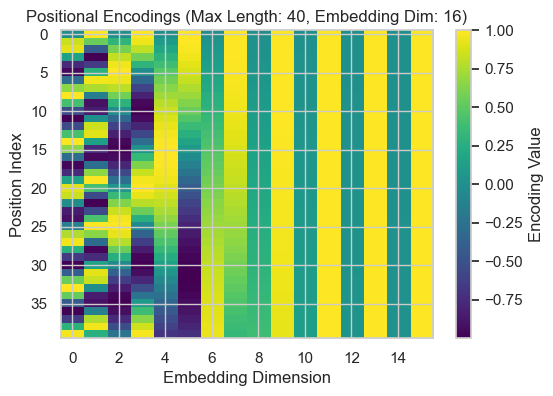

In [66]:
# Create a PositionalEncoding instance and visualize
embed_dim = 16
max_len = 40
pos_encoder = PositionalEncoding(embed_dim, max_len=max_len)
visualize_positional_encodings(pos_encoder, max_len=max_len, d_model=embed_dim, figsize=(6, 4))


## Train a Model with a Single Transformer Layer

Here we'll train our Transformer Encoder with a single transformer layer. Afterward we'll evaluate its performance and visualize the attention weights to see if we can understand what it has learned.

INSERT VIDEO HERE.

In [70]:
model = SingleHeadTransformerEncoder(vocab_size=14, embed_dim=16, hidden_dim=64, num_classes=2, num_layers=1)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=0.003)  # AdamW optimizer, default lr=0.001

device = get_device()
print(device)
model=model.to(device)

ckpt_file = MODELS_PATH / 'L09_math_transformer_one_layer.pt'
epochs = 20

score_funcs = {'ACC':accuracy_score}

cuda


In [71]:
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_metric='ACC',
                        early_stop_crit='max',
                        patience=5)

Epoch:  65%|██████▌   | 13/20 [00:10<00:05,  1.21it/s, train_loss=0.366, val_loss=0.349]

Early stopping at epoch 13


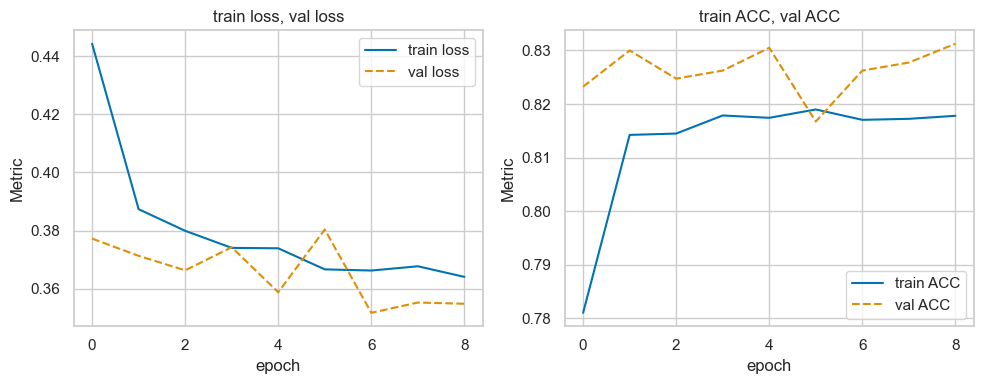

In [72]:
results = load_results(MODELS_PATH / 'L09_math_transformer_one_layer.pt')
plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

After the first epoch, the model achieves about 82% classification accuracy and never doesn't improve further.  Not coincidentally that is the percentage of sequences in the dataset where we can predict the class as positive if there are more "plus" signs than "minus" signs.  During the construction of the dataset we counted those sequences and stored them as an attribute.

In [73]:
print("Percentage of sequences correctly predicted by dominant sign:", 
      100*dataset.correct_dominant_sign/len(dataset) )

Percentage of sequences correctly predicted by dominant sign: 82.33


In [74]:
# reload the model
model = SingleHeadTransformerEncoder(vocab_size=14, embed_dim=16, hidden_dim=64, num_classes=2, num_layers=1)
model = load_model(model, MODELS_PATH / 'L09_math_transformer_one_layer.pt', device=get_device())

In [75]:
plot_attention_weights_widget(model, valid_loader, vocab)

Output()

In [76]:
display_attention(1, model, valid_loader, vocab)

<IPython.core.display.Javascript object>

## Train a Model with Two Transformer Layers

By adding a second transformer layer, the model can achieve up to 100% accuracy on the test data!  The first attention layer seems to aggregate the values of the digits and the signs while the second attention layer seems to add the signed values to get the "<CLS>" token.

INSERT VIDEO HERE

In [77]:
model = SingleHeadTransformerEncoder(vocab_size=14, 
                                     embed_dim=16, 
                                     hidden_dim=64, 
                                     num_classes=2, 
                                     num_layers=2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=0.003)  # AdamW optimizer, default lr=0.001

device = get_device()
print(device)
model=model.to(device)

ckpt_file = MODELS_PATH / 'L09_math_transformer_two_layers.pt'
epochs = 150

score_funcs = {'ACC':accuracy_score}

cuda


In [78]:
results = train_network(model,
                        loss_func,
                        train_loader,
                        device=device,
                        val_loader=valid_loader,
                        epochs = epochs,
                        optimizer = optimizer,
                        score_funcs = score_funcs,
                        checkpoint_file=ckpt_file,
                        early_stop_metric='ACC',
                        early_stop_crit='max',
                        patience=20)

Epoch: 100%|██████████| 150/150 [01:57<00:00,  1.28it/s, train_loss=2.01e-5, val_loss=6.06e-5]  


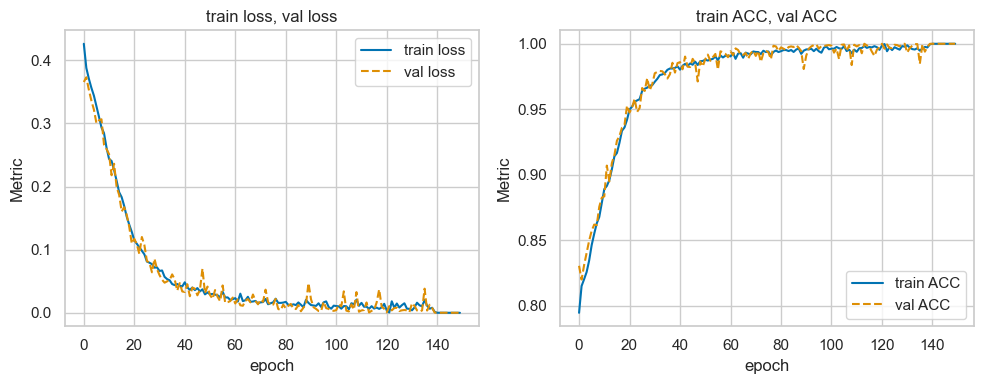

In [79]:
results = load_results(MODELS_PATH / 'L09_math_transformer_two_layers.pt')
plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

In [80]:
results.tail()

,epoch,total time,train loss,val loss,train ACC,val ACC
145,145,100.981606,0.000032,0.000063,1.0,1.0
146,146,101.658190,0.000028,0.000102,1.0,1.0
147,147,102.312065,0.000025,0.000177,1.0,1.0
148,148,102.999539,0.000022,0.000086,1.0,1.0
149,149,104.011232,0.000020,0.000061,1.0,1.0


In [81]:
# reload the model
model = SingleHeadTransformerEncoder(vocab_size=14, embed_dim=16, hidden_dim=64, 
                                     num_classes=2, num_layers=2)
model = load_model(model, MODELS_PATH / 'L09_math_transformer_two_layers.pt', device=get_device())

In [82]:
plot_attention_weights_widget(model, valid_loader, vocab)

Output()

In [83]:
display_attention(2, model, valid_loader, vocab)

<IPython.core.display.Javascript object>